In [1]:
import pandas
import requests #use requests over 'urllib.request'. Work-around for encoding problem. See: https://stackoverflow.com/questions/47419104/unicodedecodeerror-utf-8-codec-cant-decode-python3
import json
from geojson import MultiPoint
import folium
from folium import IFrame #folium does not have a .element object/attribute see https://github.com/python-visualization/folium/issues/774
from bs4 import BeautifulSoup
import geopandas as gpd
from shapely.geometry import mapping, shape
from shapely.wkt import dumps, loads

from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
import numpy as np
from scipy import special
from scipy.optimize import curve_fit

#for reading from databases
import json
import psycopg2
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *

import getpass
import datetime

import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [27]:
#connect to DB and download data
password = getpass.getpass(prompt='Password: ')
db_credentials_path = '/Users/Jacobus/Documents/Python/msu_denver_db_creds.json'
with open(db_credentials_path,'r') as f:
    db_conn_dict = json.load(f)
db_conn_dict['password'] = password

connection = psycopg2.connect(**db_conn_dict)

#read data from db
#how to select mean mentions grouped by place
df_all = gpd.read_postgis("select * from gdelt_mentions", connection, 
                            geom_col='geom', crs={'init':'epsg:4326'},
                            coerce_float=False)


connection.close()

Password: ········


In [28]:
df_all.describe()

,geores,sumtotalmentions,lon,lat
count,3097.0,3097.000000,3097.000000,3097.000000
mean,3.0,2.948983,1.494374,31.499454
std,0.0,5.821082,80.009139,22.414608
min,3.0,1.000000,-157.972000,-51.622600
25%,3.0,1.000000,-77.036400,27.833300
50%,3.0,1.000000,10.000000,37.804400
75%,3.0,3.000000,40.971400,45.416700
max,3.0,114.000000,179.483000,72.133300


In [29]:
#get unique time slices
#this is redundant to df.groupby() function
time_periods = set(df_all.urlpubtimedate)
df_all['count'] = 1

#get sum of mentions per time slice group
df_sum = df_all.groupby('urlpubtimedate').sum()
df_sum
# df_sum.sumtotalmentions['2018-02-27 17:45:00']

,geores,sumtotalmentions,lon,lat,count
urlpubtimedate,,,,,
2018-02-27 17:45:00,732,730,463.5576,8715.9684,244
2018-02-27 19:15:00,699,566,-1680.4152,7553.7771,233
2018-02-28 01:15:00,837,839,669.4261,7217.3450,279
2018-03-01 00:30:00,912,918,-2514.1475,8648.4093,304
2018-03-01 16:15:00,882,853,4495.0905,10800.2896,294
2018-03-02 01:45:00,831,902,-371.7445,8791.9239,277
2018-03-05 17:45:00,948,911,855.3247,11209.9661,316
2018-03-11 23:15:00,795,830,2403.2691,7820.2348,265
2018-03-13 00:30:00,843,801,6143.4942,6765.5675,281


In [30]:
#create new column in df_all that holds ratio of mentions to total mentions
def getSumMentions(dateTime):
    return df_sum.sumtotalmentions[dateTime]

#make new column containing the total mentions for that datetime slice
df_all['timedate_sum'] = df_all['urlpubtimedate'].apply(lambda x: getSumMentions(x))
#make new column for numMentions/totalMentions
df_all['normalized_mentions'] = df_all.sumtotalmentions/df_all.timedate_sum

#create column of proportion of mentions for each location over the entire mention total
df_all['proportion_of_total_mentions'] = df_all.sumtotalmentions / df_all.sumtotalmentions.sum()

In [12]:
unique_locations = set(df_all.coordinates)
#unique locations
print(len(unique_locations))
#total locations
print(len(df_all.coordinates))
#locations occuring on multiple datetime groups
print(len(df_all.coordinates)-len(unique_locations))

2024
3097
1073


In [31]:
df_all = df_all.sort_values(by=['proportion_of_total_mentions'],ascending=False)
df_all.head(10)

,allmentionedthemes,coordinates,geores,oneurl,sumtotalmentions,type,urlpubtimedate,lon,lat,geom,count,timedate_sum,normalized_mentions,proportion_of_total_mentions
812,;SCANDAL;TAX_WORLDLANGUAGES_ALABAMA;WB_696_PUB...,"{-77.0364,38.8951}",3,https://townhall.com/tipsheet/cortneyobrien/20...,114,Point,2018-03-01 00:30:00,-77.0364,38.8951,POINT (-77.0364 38.8951),1,918,0.124183,0.012482
2277,;EPU_ECONOMY_HISTORIC;EPU_ECONOMY_HISTORIC;TAX...,"{116.388,39.9289}",3,http://www.zaobao.com.sg/zopinions/views/story...,111,Point,2018-03-13 00:30:00,116.3880,39.9289,POINT (116.388 39.9289),1,801,0.138577,0.012154
2538,;LEADER;TAX_FNCACT_PRESIDENT;USPEC_POLITICS_GE...,"{-77.0364,38.8951}",3,http://www.ceskenoviny.cz/zpravy/trump-oznamil...,90,Point,2018-03-13 17:30:00,-77.0364,38.8951,POINT (-77.0364 38.8951),1,889,0.101237,0.009854
3023,;WB_2433_CONFLICT_AND_VIOLENCE;WB_2432_FRAGILI...,"{-77.0364,38.8951}",3,https://www.voanews.com/a/white-house-says-tru...,82,Point,2018-03-20 00:00:00,-77.0364,38.8951,POINT (-77.0364 38.8951),1,894,0.091723,0.008978
1277,;TAX_FNCACT_REPORTER;;EPU_ECONOMY_HISTORIC;USP...,"{99.3833,24.1167}",3,http://www.jhnews.com.cn/2018/0301/802168.shtml,78,Point,2018-03-01 16:15:00,99.3833,24.1167,POINT (99.38330000000001 24.1167),1,853,0.091442,0.008540
1603,;TAX_FNCACT_DIRECTOR;RESIGNATION;WB_696_PUBLIC...,"{-77.0364,38.8951}",3,https://in.reuters.com/article/us-global-marke...,65,Point,2018-03-02 01:45:00,-77.0364,38.8951,POINT (-77.0364 38.8951),1,902,0.072062,0.007117
735,;GENERAL_GOVERNMENT;EPU_POLICY_CONGRESS;TAX_FN...,"{-77.0364,38.8951}",3,https://www.b.dk/globalt/trumps-svigersoen-og-...,65,Point,2018-02-28 01:15:00,-77.0364,38.8951,POINT (-77.0364 38.8951),1,839,0.077473,0.007117
1425,;WB_1447_GERIATRICS;WB_621_HEALTH_NUTRITION_AN...,"{116.388,39.9289}",3,http://www.bjhmoh.cn/index.php?r=archives/job&...,63,Point,2018-03-02 01:45:00,116.3880,39.9289,POINT (116.388 39.9289),1,902,0.069845,0.006898
2026,;UNGP_FORESTS_RIVERS_OCEANS;TAX_DISEASE_DISEAS...,"{116.388,39.9289}",3,http://www.bjhmoh.cn/index.php?r=archives/defa...,62,Point,2018-03-11 23:15:00,116.3880,39.9289,POINT (116.388 39.9289),1,830,0.074699,0.006789
2159,;TAX_FNCACT_SUPPORTERS;TAX_POLITICAL_PARTY_REP...,"{-77.0364,38.8951}",3,http://www.sharenet.co.za/news/Trump_considers...,50,Point,2018-03-11 23:15:00,-77.0364,38.8951,POINT (-77.0364 38.8951),1,830,0.060241,0.005475


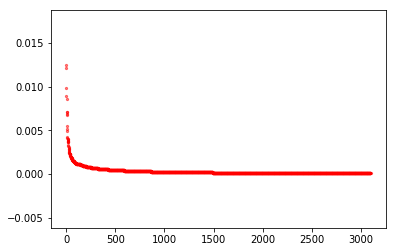

In [9]:
# n, bins, patches = plt.hist(x, 50, density=True, facecolor='g', alpha=0.75)
x = [i for i in range(0,len(df_all.sumtotalmentions))]
# y = df_all.normalized_mentions
y = df_all.proportion_of_total_mentions
plt.scatter(x,y,s=5,c="red",alpha=0.5)
# plt.ylim((ymax=1))
plt.show()

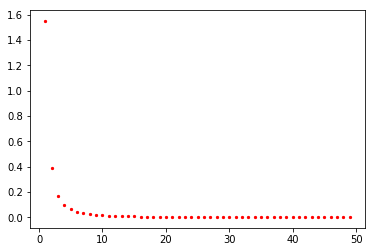

In [10]:
a = 2.0
s = np.random.zipf(a,50)
x = np.arange(1.0, 50)
y = x**(-a) / special.zetac(a)
plt.scatter(x,y,s=5,c='red')
plt.show()

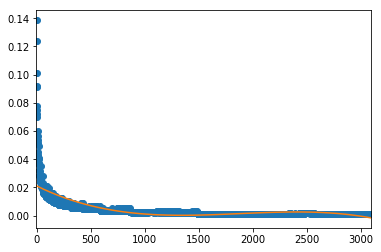

In [11]:
#simple polynomial regression best fit
#3rd degree polynomial
#see: https://stackoverflow.com/questions/19165259/python-numpy-scipy-curve-fitting

x = [i for i in range(0,len(df_all.sumtotalmentions))]
y = df_all.normalized_mentions

z = np.polyfit(x,y,3)
f = np.poly1d(z)

x_new = np.linspace(x[0],x[-1],50)
y_new = f(x_new)

plt.plot(x,y,'o',x_new,y_new)
plt.xlim(x[0]-1,x[-1]+1)
plt.show()

In [12]:
#see: https://stackoverflow.com/questions/44553480/equation-for-fitting-exponential-decay-model-in-scipy
#see for r_squared, etc: https://stackoverflow.com/questions/893657/how-do-i-calculate-r-squared-using-python-and-numpy
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)



x = [i for i in range(0,len(df_all.sumtotalmentions))]
y = df_all.normalized_mentions

def func(x, a, b, c):
    return a + b * (1 - np.exp(-c/x))

# sol = curve_fit(f, x, y, p0 = (.75,.75,200))

x_new = np.linspace(x[0],x[-1],50)
y_new = func(x_new,0,1,2)

plt.plot(x,y,'o',x_new,y_new)

plt.xlim(x[0]-1,x[-1]+1)
plt.show()


NameError: name 'scipy' is not defined

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


popt: [  4.97252458e-03   1.12097311e-01   6.66317752e+00]
pcov: [[  2.28245460e-08   1.91591368e-08  -1.20479635e-05]
 [  1.91591368e-08   2.10956130e-06  -1.83857485e-04]
 [ -1.20479635e-05  -1.83857485e-04   2.83581692e-02]]
perr: [  1.51077947e-04   1.45243289e-03   1.68398840e-01]


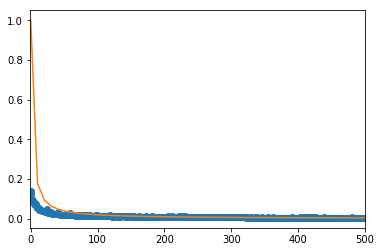

In [13]:
#see: https://stackoverflow.com/questions/44553480/equation-for-fitting-exponential-decay-model-in-scipy

x = [i for i in range(0,len(df_all.sumtotalmentions))][:500]
y = df_all.normalized_mentions[:500]

def func(x, a, b, c):
#     return a + b * (1 - np.exp(-c/x))
#     return a + b * (np.exp(-c/x))
    return a + b * (1 - np.exp(-c/x))

# sol = curve_fit(f, x, y, p0 = (.75,.75,200))

popt, pcov = curve_fit(func,x,y)
print("popt: {}".format(popt))
print("pcov: {}".format(pcov))

#see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
perr = np.sqrt(np.diag(pcov))
print("perr: {}".format(perr))

x_new = np.linspace(x[0],x[-1],50)
#params for estimating y_new go here
y_new = func(x_new,0,1,2)

plt.plot(x,y,'o',x_new,y_new)

plt.xlim(x[0]-1,x[-1]+1)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


popt: [  4.10328823  98.70281057   6.31034683]
pcov: [[ 0.00732119  0.00629759 -0.0042164 ]
 [ 0.00629759  0.72017797 -0.06740307]
 [-0.0042164  -0.06740307  0.01113506]]
perr: [ 0.08556395  0.848633    0.10552281]


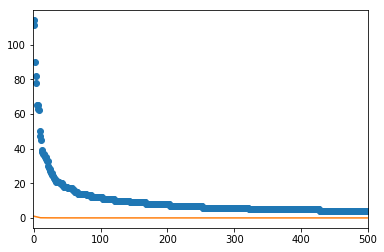

In [32]:
#do the same thing but with n mentions of N total mentions


#see: https://stackoverflow.com/questions/44553480/equation-for-fitting-exponential-decay-model-in-scipy

x = [i for i in range(0,len(df_all.sumtotalmentions))][:500]
y = df_all.sumtotalmentions[:500]

def func(x, a, b, c):
#     return a + b * (1 - np.exp(-c/x))
#     return a + b * (np.exp(-c/x))
    return a + b * (1 - np.exp(-c/x))

# sol = curve_fit(f, x, y, p0 = (.75,.75,200))

popt, pcov = curve_fit(func,x,y)
print("popt: {}".format(popt))
print("pcov: {}".format(pcov))

#see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
perr = np.sqrt(np.diag(pcov))
print("perr: {}".format(perr))

x_new = np.linspace(x[0],x[-1],50)
#parameters for estimating y_new go below
y_new = func(x_new,0,1,1)

plt.plot(x,y,'o',x_new,y_new)

plt.xlim(x[0]-1,x[-1]+1)
plt.show()

In [44]:
std = df_all.sumtotalmentions.std()
mean = df_all.sumtotalmentions.mean()

print(mean,std)


# df_trunc = df_all.where((2 < df_all.sumtotalmentions) and (df_all.sumtotalmentions < mean+std))
df_trunc = df_all[df_all.sumtotalmentions < mean+std]
df_trunc = df_trunc[df_trunc.sumtotalmentions > 2]
df_trunc.describe()
df_all = df_trunc

2.94898288666 5.82108179918


In [45]:
#measure distance from max mentions proportion and plot

from geopy.distance import vincenty

# regression of mentions as a function of distance
# distance from 'hot spots'

#let's start with the top -- add a column for distance away from place with max ratio
# with geopandas: .distance(other) returns the min distance for each element in a series to other

max_row = df_all['proportion_of_total_mentions'].idxmax()
min_row = df_all.proportion_of_total_mentions.idxmin()
max_center = (df_all.loc[max_row].lat,df_all.loc[max_row].lon)
min_center = (df_all.loc[min_row].lat,df_all.loc[min_row].lon)

penult_row = df_all.drop(max_row).proportion_of_total_mentions.idxmax()
penult_center = (df_all.loc[penult_row].lat,df_all.loc[penult_row].lon)


#vincenty is happy when you input a lat,lon tuple
#please, make vincenty happy...
df_all['coordinates_yx'] = df_all.coordinates.apply(lambda x: (x.split(',')[-1][:-1],x.split(',')[0][1:]))

df_all['dist_from_max'] = df_all.coordinates_yx.apply(lambda x: vincenty(max_center,x).meters)
df_all['dist_from_penult'] = df_all.coordinates_yx.apply(lambda x: vincenty(penult_center,x).meters)

#get distances from major population centers


# see for great circle distance calculations: https://gis.stackexchange.com/questions/84885/whats-the-difference-between-vincenty-and-great-circle-distance-calculations
# use Vincenty's formula from geopy
#d=vincenty(p1, p2).meters


# df_all['distance_from_max_geopandas'] = df_all.geom.distance(max_center)
df_all.head(5)

,allmentionedthemes,coordinates,geores,oneurl,sumtotalmentions,type,urlpubtimedate,lon,lat,geom,count,timedate_sum,normalized_mentions,proportion_of_total_mentions,coordinates_yx,dist_from_max,dist_from_penult
2774,;BAN;CRISISLEX_T08_MISSINGFOUNDTRAPPEDPEOPLE;T...,"{36.3833,33.5}",3,http://www.wz.de/home/politik/ausland/tuerkei-...,8,Point,2018-03-13 17:30:00,36.3833,33.5000,POINT (36.3833 33.5),1,889,0.008999,0.000876,"(33.5, 36.3833)",0.000000e+00,9.898328e+06
1869,;TAX_FNCACT_AGENTS;SOC_POINTSOFINTEREST_SCHOOL...,"{-87.6501,41.85}",3,http://siouxcityjournal.com/news/national/opio...,8,Point,2018-03-05 17:45:00,-87.6501,41.8500,POINT (-87.65009999999999 41.85),1,911,0.008782,0.000876,"(41.85, -87.6501)",9.898328e+06,0.000000e+00
2806,;WB_135_TRANSPORT;WB_135_TRANSPORT;WB_135_TRAN...,"{153.0,-26.5}",3,https://www.ipswichadvertiser.com.au/news/nati...,8,Point,2018-03-20 00:00:00,153.0000,-26.5000,POINT (153 -26.5),1,894,0.008949,0.000876,"(-26.5, 153.0)",1.395441e+07,1.430166e+07
1948,;WB_1428_INJURY;WB_1406_DISEASES;WB_621_HEALTH...,"{20.6547,42.3994}",3,http://fax.al/news/14672093/klubi-i-zhytjes-tr...,8,Point,2018-03-05 17:45:00,20.6547,42.3994,POINT (20.6547 42.3994),1,911,0.008782,0.000876,"(42.3994, 20.6547)",1.694521e+06,8.239841e+06
383,;GENERAL_HEALTH;MEDICAL;TAX_WORLDMAMMALS_HUMAN...,"{128.393,37.3703}",3,https://kfan.iheart.com/content/2018-02-27-us-...,8,Point,2018-02-27 19:15:00,128.3930,37.3703,POINT (128.393 37.3703),1,566,0.014134,0.000876,"(37.3703, 128.393)",8.005205e+06,1.050186e+07


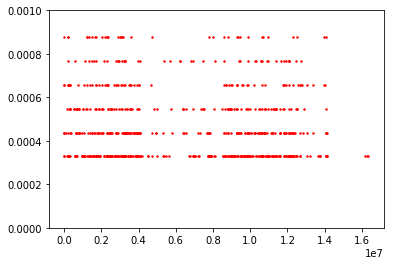

In [54]:
#plot distance against mentions proportion
x = df_all.dist_from_max
y = df_all.proportion_of_total_mentions

plt.scatter(x,y,s=2,c='red')
plt.ylim(0,0.001)
plt.show()

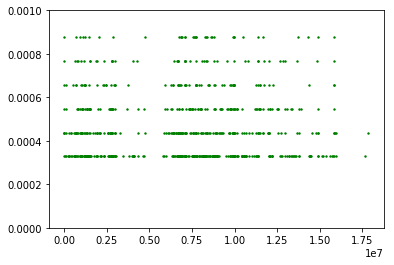

In [55]:
x = df_all.dist_from_penult
y = df_all.proportion_of_total_mentions

plt.scatter(x,y,s=2,c='green')
plt.ylim(0,0.001)
plt.show()

In [19]:
#get average mentions proportion for each lat/lon pair

groups = df_all.groupby(df_all.coordinates)
print(groups.count())
# for i in groups: print(i)

# df_all['average_mentions_per_point'] = 

                   allmentionedthemes  coordinates  geores  oneurl  \
coordinates                                                          
{-0.0833,50.9167}                   1            1       1       1   
{-0.0892,44.584}                    1            1       1       1   
{-0.1,51.3833}                      1            1       1       1   
{-0.1167,51.5}                     11           11      11      11   
{-0.15,50.8333}                     2            2       2       2   
{-0.1833,51.1667}                   2            2       2       2   
{-0.2,51.8}                         1            1       1       1   
{-0.2167,5.55}                      1            1       1       1   
{-0.2167,51.9167}                   1            1       1       1   
{-0.25,52.5833}                     1            1       1       1   
{-0.2833,51.55}                     1            1       1       1   
{-0.3268,49.1972}                   1            1       1       1   
{-0.35,5.85}        

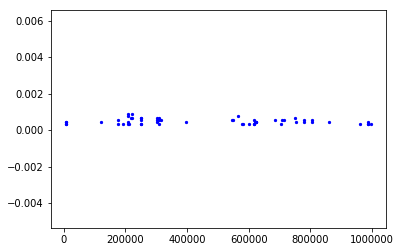

In [50]:
#get subset of data set for area surrounding each maximum



df_us = df_all[df_all.dist_from_max < 1000e3] #with dc
df_us = df_us[df_us.dist_from_max > 0]        #without dc

x = df_us.dist_from_max
y = df_us.proportion_of_total_mentions

plt.scatter(x,y,s=5,c='blue')
plt.show()